# Kann mithilfe einer NLP-unterstützten Methodik festgestellt werden ob ein Amazon Review Positiv, Neutral oder Negativ ist, bzw. kann das angegebene Voting errechnet werden?

- Michael Hermann-Hubler
- Michael Kranl

The used data was created by J. Ni, J. Li, and J. McAuley for „Justifying Recommendations using Distantly-Labeled Reviews and Fine-Grained Aspects“, in Proceedings of the 2019 Conference on mpirical Methods in Natural Language Processing and the 9th International Joint Conference on Natural Language Processing (EMNLP-IJCNLP), Hong Kong, China, 2019, S. 188–197. doi: 10.18653/v1/D19-1018. 

## Imports

In [83]:
import sys
!{sys.executable} -m pip install gzinfo
!{sys.executable} -m pip install nltk
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install wordcloud

Der Befehl "C:\Program" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.
Der Befehl "C:\Program" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.
Der Befehl "C:\Program" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.
Der Befehl "C:\Program" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.
Der Befehl "C:\Program" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


In [84]:
# Pandas
import pandas as pd

# Download
import urllib.request
import glob
import gzip
import gzinfo
import os
import shutil

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Text Preprocessing
from keras_preprocessing.text import text_to_word_sequence
import nltk
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords


[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\micha\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Load Dataset

### Download Sub Dataset

In [85]:
subdatasets = [
                  'http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Arts_Crafts_and_Sewing_5.json.gz',
                  'http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Industrial_and_Scientific_5.json.gz',
                  'http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Luxury_Beauty_5.json.gz',
                  'http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Musical_Instruments_5.json.gz'
              ]

def download(x: str):
    urllib.request.urlretrieve(x, '.data/dummy.gz')

    filename = gzinfo.read_gz_info('.data/dummy.gz').fname
    with gzip.open('.data/dummy.gz', 'rb') as f_in:
        with open('.data/' + filename, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
            
    os.remove('.data/dummy.gz')

# only run once as this can take a very long time
if len(os.listdir('.data') ) == 0:
    [download(x) for x in subdatasets]


## Load data

In [86]:
all_files = glob.glob('.data/*')
li = []

for filename in all_files:
    temp_df = pd.read_json(filename, lines=True)
    li.append(temp_df)

df = pd.concat(li, axis=0, ignore_index=True)

## Data Exploration I

In [87]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,4,True,"03 29, 2016",AIE8N9U317ZBM,0449819906,{'Format:': ' Kindle Edition'},"Zelmira, Ph.D.",Contains some interesting stitches.,Four Stars,1459209600,NaN,NaN
1,5,True,"08 12, 2015",A3ECOW0TWLH9V6,0449819906,{'Format:': ' Paperback'},Dangerous when Cooking,I'm a fairly experienced knitter of the one-co...,My current favorite go-to guide for inspiration,1439337600,18,NaN
2,4,True,"04 5, 2015",A278N8QX9TY2OS,0449819906,{'Format:': ' Paperback'},Just us,Great book but the index is terrible. Had to w...,"lots of great examples, good instructions, col...",1428192000,3,NaN
3,5,True,"10 11, 2014",A123W8HIK76XCN,0449819906,{'Format:': ' Kindle Edition'},Amazon Customer,I purchased the Kindle edition which is incred...,Another little gem by Melissa Leapman,1412985600,NaN,NaN
4,5,True,"05 8, 2014",A2A6MZ2QB4AE0L,0449819906,{'Format:': ' Paperback'},Sustainability,Very well laid out and very easy to read.\n\nT...,Very comprehensive,1399507200,NaN,NaN


In [88]:
df.describe()

,overall,unixReviewTime
count,837226.000000,8.372260e+05
mean,4.524777,1.446987e+09
std,0.953090,4.959673e+07
min,1.000000,1.051402e+09
25%,4.000000,1.418429e+09
50%,5.000000,1.452470e+09
75%,5.000000,1.483402e+09
max,5.000000,1.538525e+09


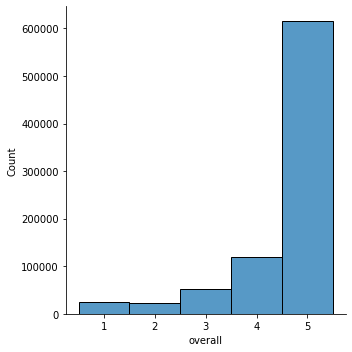

In [89]:
sns.displot(df.overall, discrete=True)

In [90]:
df.groupby('overall').count().reviewText

overall
1     25394
2     23489
3     52973
4    119795
5    615214
Name: reviewText, dtype: int64

The high average overall score means, that we have to split the data differently as we have no normal distibution.

In [91]:
print('Length whole Dataset:', len(df))
print('Length Dataset without NA:', len(df.dropna()))

Length whole Dataset: 837226
Length Dataset without NA: 5508


There exists missing Data

## Data Cleaning

### Remove unnessesary columns

In [92]:
df = df[['overall', 'reviewText']]

### Remove missing data

In [100]:
df = df.dropna()

### Reduce data to a representative subset
To reduce the data we take random 20.000 samples from each class, without replacement

In [ ]:
sampling_size = 20000

li = [
    df[df.overall == 1].sample(sampling_size),
    df[df.overall == 2].sample(sampling_size),
    df[df.overall == 3].sample(sampling_size),
    df[df.overall == 4].sample(sampling_size),
    df[df.overall == 5].sample(sampling_size)
]

df_cleaned = pd.concat(li, axis=0, ignore_index=True)

In [ ]:
df_cleaned.describe()

,overall
count,100000.000000
mean,3.000000
std,1.414221
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,5.000000


In [ ]:
df_cleaned.head()

,overall,reviewText
0,1,"Not sure how well this works with other rigs, ..."
1,1,I received a 12AX7 tube instead of the 12AU7 t...
2,1,Works flawlessly with FL Studio. I love this l...
3,1,Go buy a bottle of Liquitex Professional Gesso...
4,1,RETURNED ALSO WITH KEY BOARD


## Preprocessing

### Lowercasing

In [ ]:
df_lowercase = df_cleaned.copy()
df_lowercase.reviewText = df_lowercase.reviewText.str.lower()
df_lowercase.head()

,overall,reviewText
0,1,"not sure how well this works with other rigs, ..."
1,1,i received a 12ax7 tube instead of the 12au7 t...
2,1,works flawlessly with fl studio. i love this l...
3,1,go buy a bottle of liquitex professional gesso...
4,1,returned also with key board


### Tokenization

In [ ]:
df_token = df_lowercase.copy()
df_token.reviewText = df_token.apply(lambda row: text_to_word_sequence(row.reviewText), axis=1)
df_token.head()

,overall,reviewText
0,1,"[not, sure, how, well, this, works, with, othe..."
1,1,"[i, received, a, 12ax7, tube, instead, of, the..."
2,1,"[works, flawlessly, with, fl, studio, i, love,..."
3,1,"[go, buy, a, bottle, of, liquitex, professiona..."
4,1,"[returned, also, with, key, board]"


### Lemmatization 

In [ ]:
lemmatizer = WordNetLemmatizer()

df_lemm = df_token.copy()
df_lemm.reviewText = df_lemm.apply(lambda row: [lemmatizer.lemmatize(x) for x in row.reviewText], axis=1)
df_lemm.head()

,overall,reviewText
0,1,"[not, sure, how, well, this, work, with, other..."
1,1,"[i, received, a, 12ax7, tube, instead, of, the..."
2,1,"[work, flawlessly, with, fl, studio, i, love, ..."
3,1,"[go, buy, a, bottle, of, liquitex, professiona..."
4,1,"[returned, also, with, key, board]"


### Stemming

Stemming ist used additionally to lemtization, because time forms were not normalized

In [ ]:
stemmer = PorterStemmer()

df_stemm = df_lemm.copy()
df_stemm.reviewText = df_stemm.apply(lambda row: [stemmer.stem(x) for x in row.reviewText], axis=1)
df_stemm.head()

,overall,reviewText
0,1,"[not, sure, how, well, thi, work, with, other,..."
1,1,"[i, receiv, a, 12ax7, tube, instead, of, the, ..."
2,1,"[work, flawlessli, with, fl, studio, i, love, ..."
3,1,"[go, buy, a, bottl, of, liquitex, profession, ..."
4,1,"[return, also, with, key, board]"


### Stopword removal

In [ ]:
stopwords_en = stopwords.words('english')

df_removed_stopwords = df_stemm.copy()
df_removed_stopwords.reviewText = df_removed_stopwords.apply(lambda row: [x for x in row.reviewText if x not in stopwords_en], axis=1)
df_removed_stopwords.head()

,overall,reviewText
0,1,"[sure, well, thi, work, rig, keyboard, hook, t..."
1,1,"[receiv, 12ax7, tube, instead, 12au7, tube, i'..."
2,1,"[work, flawlessli, fl, studio, love, thi, litt..."
3,1,"[go, buy, bottl, liquitex, profession, gesso, ..."
4,1,"[return, also, key, board]"


### Define final

In [109]:
df_final = df_removed_stopwords[df_removed_stopwords.reviewText.map(lambda d: len(d)) > 0]
df_final

,overall,reviewText
0,1,"[sure, well, thi, work, rig, keyboard, hook, t..."
1,1,"[receiv, 12ax7, tube, instead, 12au7, tube, i'..."
2,1,"[work, flawlessli, fl, studio, love, thi, litt..."
3,1,"[go, buy, bottl, liquitex, profession, gesso, ..."
4,1,"[return, also, key, board]"
...,...,...
99995,5,[perfect]
99996,5,"[quick, easi, review, work, well, crimp, secur]"
99997,5,"[varianc, review, demonstr, person, string, se..."
99998,5,"[synth, snob, call, microkorg, toy, argu, feel..."


## Data Exploration II

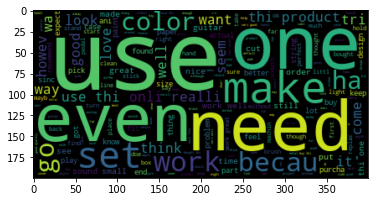

In [ ]:
word_list = df_final.reviewText.tolist()
word_list = [i for j in word_list for i in j]

word_list_text = ' '.join(word_list)

wordcloud = WordCloud().generate(word_list_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.show()

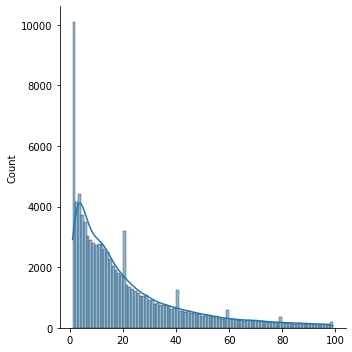

In [123]:
word_counts = [df_final.reviewText.apply(len)][0]
word_counts = [x for x in word_counts if x < 100]

sns.displot(word_counts, kde=True)

In [120]:
[x for x in df_final.reviewText if len(x) == 1][:10]

[['work'],
 ['worth'],
 ['know'],
 ['warp'],
 ['like'],
 ['good'],
 ['suck'],
 ['aw'],
 ['want'],
 ['recommend']]

These results with just one word seem plausible, thus they will be included